In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os
os.chdir('/content/gdrive/MyDrive/8 魯迅チャットボット/')

Mounted at /content/gdrive/


# 対話の学習

## １使用する文字

In [3]:
import pickle

hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞ\
ただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽ\
まみむめもゃやゅゆょよらりるれろゎわゐゑをん"

katakana = "ァアィイゥウェエォオカガキギクグケゲコゴサザシジスズセゼソゾ\
タダチヂッツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポ\
マミムメモャヤュユョヨラリルレロヮワヰヱヲンヴ"

chars = hiragana + katakana

with open("kana_rojin.txt", mode="r", encoding="utf-8") as f: 
    text = f.read()
    
for char in text:  # ひらがな、カタカナ以外でコーパスに使われている文字を追加
    if char not in chars:
        chars += char
        
chars += "\t\n"  # タブと改行を追加
        
chars_list = sorted(list(chars))  # 文字列をリストに変換してソートする
print(chars_list)

with open("kana_chars.pickle", mode="wb") as f:  # pickleで保存
    pickle.dump(chars_list, f)

['\t', '\n', '!', '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'C', 'M', 'N', 'O', 'P', 'Q', 'a', 'd', 'e', 'f', 'h', 'i', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'y', '×', '―', '○', '、', '。', '々', '〆', '〇', 'ぁ', 'あ', 'ぃ', 'い', 'ぅ', 'う', 'ぇ', 'え', 'ぉ', 'お', 'か', 'が', 'き', 'ぎ', 'く', 'ぐ', 'け', 'げ', 'こ', 'ご', 'さ', 'ざ', 'し', 'じ', 'す', 'ず', 'せ', 'ぜ', 'そ', 'ぞ', 'た', 'だ', 'ち', 'ぢ', 'っ', 'つ', 'づ', 'て', 'で', 'と', 'ど', 'な', 'に', 'ぬ', 'ね', 'の', 'は', 'ば', 'ぱ', 'ひ', 'び', 'ぴ', 'ふ', 'ぶ', 'ぷ', 'へ', 'べ', 'ぺ', 'ほ', 'ぼ', 'ぽ', 'ま', 'み', 'む', 'め', 'も', 'ゃ', 'や', 'ゅ', 'ゆ', 'ょ', 'よ', 'ら', 'り', 'る', 'れ', 'ろ', 'ゎ', 'わ', 'ゐ', 'ゑ', 'を', 'ん', 'ゝ', 'ゞ', 'ァ', 'ア', 'ィ', 'イ', 'ゥ', 'ウ', 'ェ', 'エ', 'ォ', 'オ', 'カ', 'ガ', 'キ', 'ギ', 'ク', 'グ', 'ケ', 'ゲ', 'コ', 'ゴ', 'サ', 'ザ', 'シ', 'ジ', 'ス', 'ズ', 'セ', 'ゼ', 'ソ', 'ゾ', 'タ', 'ダ', 'チ', 'ヂ', 'ッ', 'ツ', 'ヅ', 'テ', 'デ', 'ト', 'ド', 'ナ', 'ニ', 'ヌ', 'ネ', 'ノ', 'ハ', 'バ', 'パ', 'ヒ', 'ビ', 'ピ', 'フ', 'ブ', 'プ', 'ヘ', 'ベ', 'ペ', 'ホ', 'ボ', 'ポ', 'マ', 'ミ', 'ム', 'メ', 'モ', 'ャ

## ２文字のベクトル化

In [4]:
import numpy as np

# インデックスと文字で辞書を作成
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars_list):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars_list):
    indices_char[i] = char
    
seperator = "。"
sentence_list = text.split(seperator) 
sentence_list.pop() 
sentence_list = [x+seperator for x in sentence_list]

max_sentence_length = 128  # 文章の最大長さ。これより長い文章はカットされる。
sentence_list = [sentence for sentence in sentence_list if len(sentence) <= max_sentence_length]  # 長すぎる文章のカット

n_char = len(chars_list)  # 文字の種類の数
n_sample = len(sentence_list) - 1  # サンプル数

x_sentences = []  # 入力の文章
t_sentences = []  # 正解の文章
for i in range(n_sample):
    x_sentences.append(sentence_list[i])
    t_sentences.append("\t" + sentence_list[i+1] + "\n")  # 正解は先頭にタブ、末尾に改行を加える
max_length_x = max_sentence_length  # 入力文章の最大長さ
max_length_t = max_sentence_length + 2  # 正解文章の最大長さ

x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)  # encoderへの入力
x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderへの入力
t_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderの正解

for i in range(n_sample):
    x_sentence = x_sentences[i]
    t_sentence = t_sentences[i]
    for j, char in enumerate(x_sentence):
        x_encoder[i, j, char_indices[char]] = 1  # encoderへの入力をone-hot表現で表す
    for j, char in enumerate(t_sentence):
        x_decoder[i, j, char_indices[char]] = 1  # decoderへの入力をone-hot表現で表す
        if j > 0:  # 正解は入力より1つ前の時刻のものにする
            t_decoder[i, j-1, char_indices[char]] = 1
            
print(x_encoder.shape)

<ipython-input-4-73e6e01929f6>:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_encoder = np.zeros((n_sample, max_length_x, n_char), dtype=np.bool)  # encoderへの入力
<ipython-input-4-73e6e01929f6>:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_decoder = np.zeros((n_sample, max_length_t, n_char), dtype=np.bool)  # decoderへの入力
<ipython-input-4-7

(3124, 128, 230)


## ３各設定

In [5]:
batch_size = 32
epochs = 1000
n_mid = 256  # 中間層のニューロン数

## ４学習用モデルの構築

In [6]:
from keras.models import Model
from keras.layers import Dense, GRU, Input, Masking

encoder_input = Input(shape=(None, n_char))
encoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
encoder_masked = encoder_mask(encoder_input)
encoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_state=True)  # dropoutを設定し、ニューロンをランダムに無効にする
encoder_output, encoder_state_h = encoder_lstm(encoder_masked)

decoder_input = Input(shape=(None, n_char))
decoder_mask = Masking(mask_value=0)  # 全ての要素が0であるベクトルの入力は無視する
decoder_masked = decoder_mask(decoder_input)
decoder_lstm = GRU(n_mid, dropout=0.2, recurrent_dropout=0.2, return_sequences=True, return_state=True)  # dropoutを設定
decoder_output, _ = decoder_lstm(decoder_masked, initial_state=encoder_state_h)  # encoderの状態を初期状態にする
decoder_dense = Dense(n_char, activation='softmax')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)

model.compile(loss="categorical_crossentropy", optimizer="rmsprop")
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 230)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 230)]  0           []                               
                                                                                                  
 masking (Masking)              (None, None, 230)    0           ['input_1[0][0]']                
                                                                                                  
 masking_1 (Masking)            (None, None, 230)    0           ['input_2[0][0]']                
                                                                                              

## ５学習

In [ ]:
from keras.callbacks import EarlyStopping 

# val_lossに改善が見られなくなってから、30エポックで学習は終了
early_stopping = EarlyStopping(monitor="val_loss", patience=30) 

history = model.fit([x_encoder, x_decoder], t_decoder,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.1,  # 10%は検証用
                     callbacks=[early_stopping])

Epoch 1/1000
88/88 [==============================] - 84s 887ms/step - loss: 1.4306 - val_loss: 1.4413
Epoch 2/1000
88/88 [==============================] - 76s 870ms/step - loss: 1.3033 - val_loss: 1.3413
Epoch 3/1000
88/88 [==============================] - 78s 881ms/step - loss: 1.2422 - val_loss: 1.2972
Epoch 4/1000
88/88 [==============================] - 77s 873ms/step - loss: 1.2150 - val_loss: 1.2767
Epoch 5/1000
88/88 [==============================] - 78s 881ms/step - loss: 1.1961 - val_loss: 1.2581
Epoch 6/1000
88/88 [==============================] - 77s 871ms/step - loss: 1.1815 - val_loss: 1.2431
Epoch 7/1000
88/88 [==============================] - 76s 869ms/step - loss: 1.1701 - val_loss: 1.2359
Epoch 8/1000
88/88 [==============================] - 77s 877ms/step - loss: 1.1603 - val_loss: 1.2281
Epoch 9/1000
88/88 [==============================] - 76s 863ms/step - loss: 1.1528 - val_loss: 1.2213
Epoch 10/1000
88/88 [==============================] - 76s 858ms/step - l

## ６学習の推移

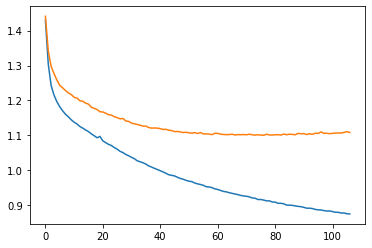

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(loss)), loss)
plt.plot(np.arange(len(val_loss)), val_loss)
plt.show()

## ７予測用モデルの構築

In [ ]:
# encoderのモデル
encoder_model = Model(encoder_input, encoder_state_h)

# decoderのモデル
decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h]

decoder_output, decoder_state_h = decoder_lstm(decoder_input,
                                               initial_state=decoder_state_in_h)
decoder_output = decoder_dense(decoder_output)

decoder_model = Model([decoder_input] + decoder_state_in,
                      [decoder_output, decoder_state_h])

# モデルの保存
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## ８返答作成用の関数

In [ ]:
def respond(input_data, beta=5):
    state_value = encoder_model.predict(input_data)
    y_decoder = np.zeros((1, 1, n_char))  # decoderの出力を格納する配列
    y_decoder[0][0][char_indices["\t"]] = 1  # decoderの最初の入力はタブ。one-hot表現にする。

    respond_sentence = ""  # 返答の文字列
    while True:
        y, h = decoder_model.predict([y_decoder, state_value])
        p_power = y[0][0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power)) 
        next_char = indices_char[next_index]  # 次の文字

        if (next_char == "\n" or len(respond_sentence) >= max_length_x):
            break  # 次の文字が改行のとき、もしくは最大文字数を超えたときは終了
            
        respond_sentence += next_char
        y_decoder = np.zeros((1, 1, n_char))  # 次の時刻の入力
        y_decoder[0][0][next_index] = 1

        state_value = h  # 次の時刻の状態

    return respond_sentence

## ９動作の確認
訓練データの最初の100文を使って、どのような返答が返ってくるかを確かめる。

In [ ]:
for i in range(100):  
    x_in = x_encoder[i:i+1]  # 入力
    responce = respond(x_in)  # 返答
    print("Input:", x_sentences[i])
    print("Response:", responce)
    print()